## Sentiment Analysis using FEEL-IT and SENTITA classifiers

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import spacy
import seaborn as sns
import time
from feel_it import EmotionClassifier, SentimentClassifier
from sentita import calculate_polarity

C:\Users\loren\anaconda3\envs\nlp_sentita\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\loren\anaconda3\envs\nlp_sentita\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\loren\anaconda3\envs\nlp_sentita\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\loren\anaconda3\envs\nlp_sentita\lib\site-pack

In [2]:
# Prevent the kernel from dying
# Demand to the RAM is too high -> on my computer, a 8GB RAM is installed
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
nlp = spacy.load('it_core_news_md')

In [4]:
sentiment_classifier = SentimentClassifier()

In [ ]:
#emotion_classifier = EmotionClassifier()

In [5]:
# Sentita

def evaluate_chunk_sentiment_sentita(TG_chunks, pred_values):
    '''Divide the whole sentences list into 10 chunks,
    based on the time interval of the broadcast they belong to.
    For every chunk, compute the negativity score
    '''
    pred_chunks = np.array_split(pred_values, 10)
    pred_chunks = [arr.tolist() for arr in pred_chunks]
    for idx, chunk in enumerate(pred_chunks):
        TG_chunks[idx].append(round(np.mean(chunk),2))

In [6]:
# FEEL-IT

def evaluate_document_sentiment(pred_values):
    '''Determine which sentiment is prevalent
    and to what extent
    '''
    if pred_values.count(0) >= pred_values.count(1):
        doc_sentiment = 'negative'
    else:
        doc_sentiment = 'positive'
    negative_degree = round(pred_values.count(0) / len(pred_values) * 100)
    return doc_sentiment, negative_degree

In [7]:
# FEEL-IT

def evaluate_chunk_sentiment_feelit(TG_chunks, pred_values):
    '''Divide the list containing sentences into 10 chunks,
    based on the time interval of the broadcast they belong to.
    For every chunk, compute the negativity score
    '''
    pred_chunks = np.array_split(pred_values, 10)
    pred_chunks = [arr.tolist() for arr in pred_chunks]
    for idx, chunk in enumerate(pred_chunks):
        _, neg_score = evaluate_document_sentiment(chunk)
        TG_chunks[idx].append(neg_score)

In [8]:
# FEEL-IT

def evaluate_document_emotions(pred_values):
    ''' Count total number of sentences 
    labelled with a specific emotion
    '''
    anger_count = pred_values.count('anger')
    fear_count = pred_values.count('fear') 
    joy_count = pred_values.count('joy')
    sadness_count = pred_values.count('sadness')    

    return anger_count, fear_count, joy_count, sadness_count

In [9]:
# Create empty lists to store day-to-day polarity detection 
# for each TV news
TGA_scores_sentita = []
TGB_scores_sentita = []
TGC_scores_sentita = []

TGA_scores_feelit = []
TGB_scores_feelit = []
TGC_scores_feelit = []

In [10]:
# Create empty lists to store polarity evolution within newscasts
TGA_chunks_sentita = []
TGB_chunks_sentita = []
TGC_chunks_sentita = []

TGA_chunks_feelit = []
TGB_chunks_feelit = []
TGC_chunks_feelit = []

for i in range(10):
    # During each iteration, add an empty list to the list named TG*_chunks_sentita or TG*_chunks_feelit
    TGA_chunks_sentita.append([])
    TGB_chunks_sentita.append([])
    TGC_chunks_sentita.append([])
    
    TGA_chunks_feelit.append([])
    TGB_chunks_feelit.append([])
    TGC_chunks_feelit.append([])

In [11]:
# Create empty lists to be filled with all TV news sentences
TGA_sents = []
TGB_sents = []
TGC_sents = []

# Create empty lists to be filled with sentences score
TGA_scores_sents_sentita = []
TGB_scores_sents_sentita = []
TGC_scores_sents_sentita = []

TGA_scores_sents_feelit = []
TGB_scores_sents_feelit = []
TGC_scores_sents_feelit = []

In [12]:
# Create empty lists to compute sentences emotion scores
# for each TV news
TGA_anger = []
TGA_fear = []
TGA_joy = []
TGA_sadness = []
TGB_anger = []
TGB_fear = []
TGB_joy = []
TGB_sadness = []
TGC_anger = []
TGC_fear = []
TGC_joy = []
TGC_sadness = []

In [13]:
start = time.time()
# Set the path where TV news transcripts are stored
file_path = "C:\\Users\\loren\\Documents\\Personali\\Università\\UNIMI\\CORSI\\YEAR 2\\Text Mining and Sentiment Analysis\\Trascrizioni\\"

print('### SENTIMENT ANALYSIS WITH SENTITA CLASSIFIER ###\n')
files = os.listdir(file_path)
for idx_file,file_name in enumerate(files):
    tv_news_name = file_name[:3]
    with open(file_path + file_name, encoding='utf-8') as f:
        data = json.load(f)
        
        print(f"Now {file_name} is being extracted")
       
        # From a transcript to a list of sentences
        txt = data['results']['transcripts'][0]['transcript']
        doc = nlp(txt)
        sents = [sent.text for sent in doc.sents]

        # Day-to-day polarity detection (Sentita)
        _, sentiment_pred_sentita = calculate_polarity(sents)
        neg_scores_sentita = [0 if pos_score>neg_score else 1 for pos_score,neg_score in sentiment_pred_sentita]
        # Remove the hashtag, if you want to calculate the exact polarity score for each sentence
        #neg_scores_sentita = [int(np.ceil(neg_score/(pos_score+neg_score)*100)) for pos_score,neg_score in sentiment_pred]

        if tv_news_name=='TGA':
            TGA_sents.extend(sents)
            # Scores (Sentita)
            TGA_scores_sentita.append(round(np.mean(neg_scores_sentita),2))
            TGA_scores_sents_sentita.extend(neg_scores_sentita)
            evaluate_chunk_sentiment_sentita(TGA_chunks_sentita, neg_scores_sentita)
        elif tv_news_name=='TGB':
            TGB_sents.extend(sents)
            # Scores (Sentita)
            TGB_scores_sentita.append(round(np.mean(neg_scores_sentita),2))
            TGB_scores_sents_sentita.extend(neg_scores_sentita)
            evaluate_chunk_sentiment_sentita(TGB_chunks_sentita, neg_scores_sentita)
        elif tv_news_name=='TGC':
            TGC_sents.extend(sents)
            # Scores (Sentita)
            TGC_scores_sentita.append(round(np.mean(neg_scores_sentita),2))
            TGC_scores_sents_sentita.extend(neg_scores_sentita)
            evaluate_chunk_sentiment_sentita(TGC_chunks_sentita, neg_scores_sentita)        

        # Once text from all the files inside the directory have been extracted,
        # migrate sentences saved for each TV news into distinct dataframes
        if idx_file == len(files)-1:
            df_A = pd.DataFrame()
            df_A['Sentence'] = TGA_sents
            df_A['Sentita score'] = TGA_scores_sents_sentita
            df_B = pd.DataFrame()
            df_B['Sentence'] = TGB_sents
            df_B['Sentita score'] = TGB_scores_sents_sentita
            df_C = pd.DataFrame()
            df_C['Sentence'] = TGC_sents
            df_C['Sentita score'] = TGC_scores_sents_sentita
            
        current_time = time.time()
        print(f"Elapsed time {round(current_time - start, 2)} seconds\n")

### SENTIMENT ANALYSIS WITH SENTITA CLASSIFIER ###

Now TGA20220502.json is being extracted
Elapsed time 19.37 seconds

Now TGA20220503.json is being extracted
Elapsed time 34.94 seconds

Now TGA20220504.json is being extracted
Elapsed time 49.2 seconds

Now TGA20220505.json is being extracted
Elapsed time 62.11 seconds

Now TGA20220506.json is being extracted
Elapsed time 76.3 seconds

Now TGA20220507.json is being extracted
Elapsed time 90.2 seconds

Now TGA20220508.json is being extracted
Elapsed time 104.41 seconds

Now TGB20220502.json is being extracted
Elapsed time 119.37 seconds

Now TGB20220503.json is being extracted
Elapsed time 131.97 seconds

Now TGB20220504.json is being extracted
Elapsed time 145.6 seconds

Now TGB20220505.json is being extracted
Elapsed time 161.6 seconds

Now TGB20220506.json is being extracted
Elapsed time 176.05 seconds

Now TGB20220507.json is being extracted
Elapsed time 189.85 seconds

Now TGB20220508.json is being extracted
Elapsed time 204.46 se

In [14]:
start = time.time()
# Set the path where TV news transcripts are stored
file_path = "C:\\Users\\loren\\Documents\\Personali\\Università\\UNIMI\\CORSI\\YEAR 2\\Text Mining and Sentiment Analysis\\Trascrizioni\\"

print('### SENTIMENT ANALYSIS WITH FEEL-IT CLASSIFIER ###\n')
files = os.listdir(file_path)
for idx_file,file_name in enumerate(files):
    tv_news_name = file_name[:3]
    with open(file_path + file_name, encoding='utf-8') as f:
        data = json.load(f)
        
        print(f"Now {file_name} is being extracted")
       
        # From a transcript to a list of sentences
        txt = data['results']['transcripts'][0]['transcript']
        doc = nlp(txt)
        sents = [sent.text for sent in doc.sents]
        
        # Day-to-day polarity detection (FEEL-IT)
        sentiment_pred_feelit = sentiment_classifier.predict(sents)        
        sentiment_pred_binary = list(map(lambda sent: 1 if sent=='positive' else 0, sentiment_pred_feelit))

        doc_sentiment, neg_score_feelit = evaluate_document_sentiment(sentiment_pred_binary)

        if tv_news_name=='TGA':
            # Scores (FEEL-IT)
            TGA_scores_feelit.append(neg_score_feelit)
            TGA_scores_sents_feelit.extend(sentiment_pred_binary)
            evaluate_chunk_sentiment_feelit(TGA_chunks_feelit, sentiment_pred_binary)
        elif tv_news_name=='TGB':
            # Scores (FEEL-IT)
            TGB_scores_feelit.append(neg_score_feelit)
            TGB_scores_sents_feelit.extend(sentiment_pred_binary)
            evaluate_chunk_sentiment_feelit(TGB_chunks_feelit, sentiment_pred_binary)
        elif tv_news_name=='TGC':      
            # Scores (FEEL-IT)
            TGC_scores_feelit.append(neg_score_feelit)
            TGC_scores_sents_feelit.extend(sentiment_pred_binary)
            evaluate_chunk_sentiment_feelit(TGC_chunks_feelit, sentiment_pred_binary)
        
        '''
        # One-week emotions detection (FEEL-IT)
        emotions_pred = emotion_classifier.predict(sents)
        
        if tv_news_name=='TGA':
            TGA_anger.append(evaluate_document_emotions(emotions_pred)[0])
            TGA_fear.append(evaluate_document_emotions(emotions_pred)[1])
            TGA_joy.append(evaluate_document_emotions(emotions_pred)[2])
            TGA_sadness.append(evaluate_document_emotions(emotions_pred)[3])
        elif tv_news_name=='TGB':
            TGB_anger.append(evaluate_document_emotions(emotions_pred)[0])
            TGB_fear.append(evaluate_document_emotions(emotions_pred)[1])
            TGB_joy.append(evaluate_document_emotions(emotions_pred)[2])
            TGB_sadness.append(evaluate_document_emotions(emotions_pred)[3])
        elif tv_news_name=='TGC':
            TGC_anger.append(evaluate_document_emotions(emotions_pred)[0])
            TGC_fear.append(evaluate_document_emotions(emotions_pred)[1])
            TGC_joy.append(evaluate_document_emotions(emotions_pred)[2])
            TGC_sadness.append(evaluate_document_emotions(emotions_pred)[3]) 
        '''
        
        # Once text from all the files inside the directory have been extracted,
        # migrate sentences saved for each TV news into distinct dataframes
        if idx_file == len(files)-1:
            df_A['FEEL-IT score'] = TGA_scores_sents_feelit
            df_B['FEEL-IT score'] = TGB_scores_sents_feelit
            df_C['FEEL-IT score'] = TGC_scores_sents_feelit
            
        current_time = time.time()
        print(f"Elapsed time {round(current_time - start, 2)} seconds\n")

### SENTIMENT ANALYSIS WITH FEEL-IT CLASSIFIER ###

Now TGA20220502.json is being extracted
Elapsed time 136.14 seconds

Now TGA20220503.json is being extracted
Elapsed time 284.65 seconds

Now TGA20220504.json is being extracted
Elapsed time 411.84 seconds

Now TGA20220505.json is being extracted
Elapsed time 521.46 seconds

Now TGA20220506.json is being extracted
Elapsed time 665.84 seconds

Now TGA20220507.json is being extracted
Elapsed time 763.34 seconds

Now TGA20220508.json is being extracted
Elapsed time 906.26 seconds

Now TGB20220502.json is being extracted
Elapsed time 1000.0 seconds

Now TGB20220503.json is being extracted
Elapsed time 1064.95 seconds

Now TGB20220504.json is being extracted
Elapsed time 1136.88 seconds

Now TGB20220505.json is being extracted
Elapsed time 1218.84 seconds

Now TGB20220506.json is being extracted
Elapsed time 1324.14 seconds

Now TGB20220507.json is being extracted
Elapsed time 1441.0 seconds

Now TGB20220508.json is being extracted
Elapsed

### Visualization part

### Day-to-day polarity detection

In [15]:
# Convert to percentage (code could be improved elsewhere)
TGA_scores_feelit = [score/100 for score in TGA_scores_feelit]
TGB_scores_feelit = [score/100 for score in TGB_scores_feelit]
TGC_scores_feelit = [score/100 for score in TGC_scores_feelit]

In [41]:
# Convert to percentage (code could be improved elsewhere)
for idx_chunk,chunk in enumerate(TGA_chunks_feelit):
    for idx_score,score in enumerate(chunk):
        TGA_chunks_feelit[idx_chunk][idx_score] = round(score/100,2)

for idx_chunk,chunk in enumerate(TGB_chunks_feelit):
    for idx_score,score in enumerate(chunk):
        TGB_chunks_feelit[idx_chunk][idx_score] = round(score/100,2)
        
for idx_chunk,chunk in enumerate(TGC_chunks_feelit):
    for idx_score,score in enumerate(chunk):
        TGC_chunks_feelit[idx_chunk][idx_score] = round(score/100,2)

'\nfor idx_chunk,chunk in enumerate(TGC_chunks_feelit):\n    for idx_score,score in enumerate(chunk):\n        TGC_chunks_feelit[idx_chunk][idx_score] = round(score/100,2)\n'

In [17]:
# Add one-week polarity detected for each TV news 
# to the lists of already existing day-to-day polarity scores 
TGA_scores_sentita.append(round(np.mean(TGA_scores_sentita),2))
TGB_scores_sentita.append(round(np.mean(TGB_scores_sentita),2))
TGC_scores_sentita.append(round(np.mean(TGC_scores_sentita),2))

TGA_scores_feelit.append(round(np.mean(TGA_scores_feelit),2))
TGB_scores_feelit.append(round(np.mean(TGB_scores_feelit),2))
TGC_scores_feelit.append(round(np.mean(TGC_scores_feelit),2))

In [20]:
barplot_sentiment_index = ['2/5','3/5','4/5','5/5','6/5','7/5','8/5','OVERALL']

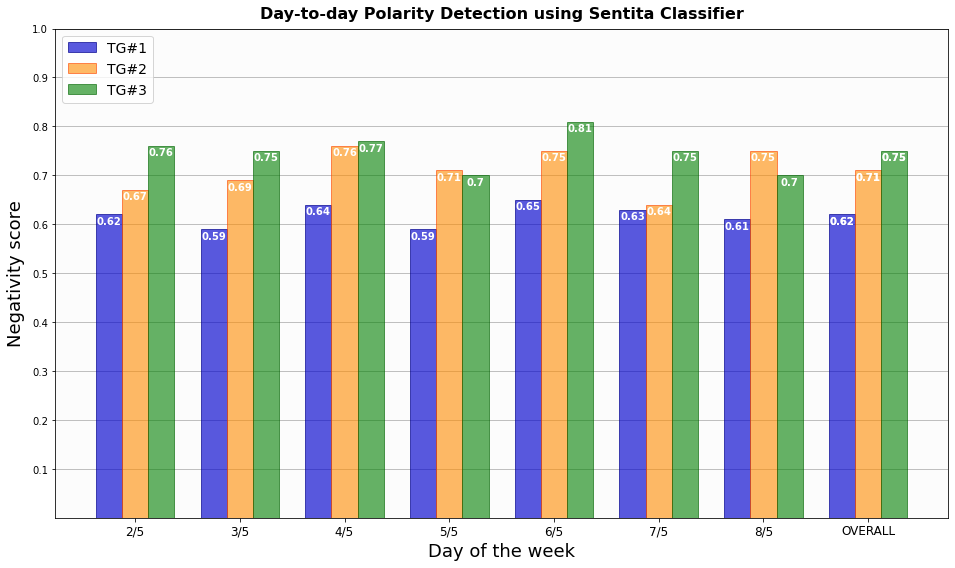

In [95]:
# Sentita

#sns.set() # call sns.reset_orig() to get back to the original background

fig, ax = plt.subplots(figsize=(16,9))
width = 0.25
TGA_bars = ax.bar(np.arange(len(TGA_scores_sentita)) - width, TGA_scores_sentita, width=width, label='TG#1', color='mediumblue', edgecolor='darkblue', alpha=0.65)
TGB_bars = ax.bar(barplot_sentiment_index, TGB_scores_sentita, width=width, label='TG#2', color='darkorange', edgecolor='orangered', alpha=0.6)
TGC_bars = ax.bar(np.arange(len(TGC_scores_sentita)) + width, TGC_scores_sentita, width=width, label='TG#3', color='green', edgecolor='darkgreen', alpha=0.6)

# Set plot background color
ax.set_facecolor('#fcfcfc')

# Change the color of the left and bottom spines to black
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

# Labels
ax.set_xlabel("Day of the week", labelpad=5)
ax.set_ylabel("Negativity score", labelpad=7)
# Tweak the axis labels
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_size(18)
#ylab.set_style('italic')
ylab.set_size(18)

# Ticks 
xtick = ax.set_xticks(barplot_sentiment_index)
ax.tick_params(axis='x', which='major', labelsize=12)
ytick = ax.set_yticks(np.arange(0.1,1.1,0.1))

# Add values to bars
'''for i in range(len(barplot_sentiment_index)):
    plt.text(i-width,TGA_scores[i]+0.005,TGA_scores[i],ha='center')
    plt.text(i,TGB_scores[i]+0.005,TGB_scores[i],ha='center')
    plt.text(i+width,TGC_scores[i]+0.005,TGC_scores[i],ha='center')
    if i==7:
        plt.text(i-width,TGA_scores[i]+0.005,TGA_scores[i],ha='center')
        plt.text(i,TGB_scores[i]+0.005,TGB_scores[i],ha='center')
        plt.text(i+width,TGC_scores[i]+0.005,TGC_scores[i],ha='center')
'''    
for i in range(len(barplot_sentiment_index)):
    plt.text(i-width,TGA_scores_sentita[i]-0.02,TGA_scores_sentita[i],color='white',fontweight='bold',ha='center')
    plt.text(i,TGB_scores_sentita[i]-0.02,TGB_scores_sentita[i],color='white',fontweight='bold',ha='center')
    plt.text(i+width,TGC_scores_sentita[i]-0.02,TGC_scores_sentita[i],color='white',fontweight='bold',ha='center')
    if i==7:
        plt.text(i-width,TGA_scores_sentita[i]-0.02,TGA_scores_sentita[i],color='white',fontweight='bold',ha='center')
        plt.text(i,TGB_scores_sentita[i]-0.02,TGB_scores_sentita[i],color='white',fontweight='bold',ha='center')
        plt.text(i+width,TGC_scores_sentita[i]-0.02,TGC_scores_sentita[i],color='white',fontweight='bold',ha='center')  

# Title
ttl = ax.set_title('Day-to-day Polarity Detection using Sentita Classifier', pad=10)
ttl.set_weight('bold')
ttl.set_size(16)
ax.legend(fontsize=14, loc='upper left')
ax.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

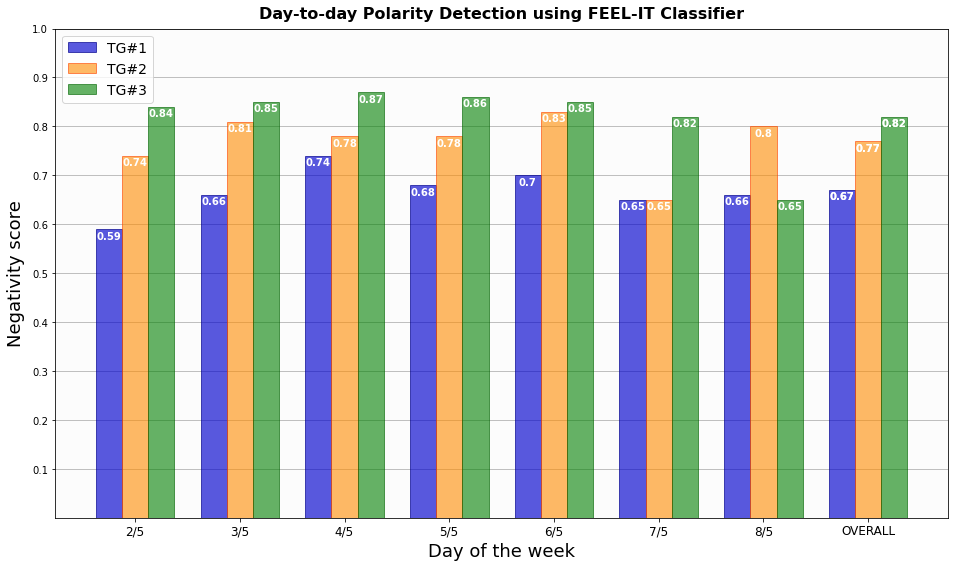

In [97]:
# FEEL-IT

#sns.set() # call sns.reset_orig() to get back to the original background

fig, ax = plt.subplots(figsize=(16,9))
width = 0.25
TGA_bars = ax.bar(np.arange(len(TGA_scores_feelit)) - width, TGA_scores_feelit, width=width, label='TG#1', color='mediumblue', edgecolor='darkblue', alpha=0.65)
TGB_bars = ax.bar(barplot_sentiment_index, TGB_scores_feelit, width=width, label='TG#2', color='darkorange', edgecolor='orangered', alpha=0.6)
TGC_bars = ax.bar(np.arange(len(TGC_scores_feelit)) + width, TGC_scores_feelit, width=width, label='TG#3', color='green', edgecolor='darkgreen', alpha=0.6)

# Set plot background color
ax.set_facecolor('#fcfcfc')

# Change the color of the left and bottom spines to black
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

# Labels
ax.set_xlabel("Day of the week", labelpad=5)
ax.set_ylabel("Negativity score", labelpad=7)
# Tweak the axis labels
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_size(18)
#ylab.set_style('italic')
ylab.set_size(18)

# Ticks 
xtick = ax.set_xticks(barplot_sentiment_index)
ax.tick_params(axis='x', which='major', labelsize=12)
ytick = ax.set_yticks(np.arange(0.1,1.1,0.1))

# Add values to bars
for i in range(len(barplot_sentiment_index)):
    plt.text(i-width,TGA_scores_feelit[i]-0.02,TGA_scores_feelit[i],color='white',fontweight='bold',ha='center')
    plt.text(i,TGB_scores_feelit[i]-0.02,TGB_scores_feelit[i],color='white',fontweight='bold',ha='center')
    plt.text(i+width,TGC_scores_feelit[i]-0.02,TGC_scores_feelit[i],color='white',fontweight='bold',ha='center')
    if i==7:
        plt.text(i-width,TGA_scores_feelit[i]-0.02,TGA_scores_feelit[i],color='white',fontweight='bold',ha='center')
        plt.text(i,TGB_scores_feelit[i]-0.02,TGB_scores_feelit[i],color='white',fontweight='bold',ha='center')
        plt.text(i+width,TGC_scores_feelit[i]-0.02,TGC_scores_feelit[i],color='white',fontweight='bold',ha='center')  

# Title
ttl = ax.set_title('Day-to-day Polarity Detection using FEEL-IT Classifier', pad=10)
ttl.set_weight('bold')
ttl.set_size(16)
ax.legend(fontsize=14, loc='upper left')
ax.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

### Polarity evolution within newscasts

In [29]:
# Sentita

TGA_chunks_avg_score = []
TGB_chunks_avg_score = []
TGC_chunks_avg_score = []

TGA_chunks_std_error = []
TGB_chunks_std_error = []
TGC_chunks_std_error = []

for chunks_list in [TGA_chunks_sentita,TGB_chunks_sentita,TGC_chunks_sentita]:  
    for chunk_scores in chunks_list: 
        if chunks_list == TGA_chunks_sentita:
            # Compute chunk mean score
            avg_score = np.mean(chunk_scores)
            TGA_chunks_avg_score.append(avg_score)
            # Compute chunk standard error
            std_error = round(np.std(chunk_scores),2)
            TGA_chunks_std_error.append(std_error)
        elif chunks_list == TGB_chunks_sentita:
            # Compute chunk mean score
            avg_score = np.mean(chunk_scores)
            TGB_chunks_avg_score.append(avg_score)
            # Compute chunk standard error
            std_error = round(np.std(chunk_scores),2)
            TGB_chunks_std_error.append(std_error)
        elif chunks_list == TGC_chunks_sentita:
            # Compute chunk mean score
            avg_score = np.mean(chunk_scores)
            TGC_chunks_avg_score.append(avg_score)
            # Compute chunk standard error
            std_error = round(np.std(chunk_scores),2)
            TGC_chunks_std_error.append(std_error)

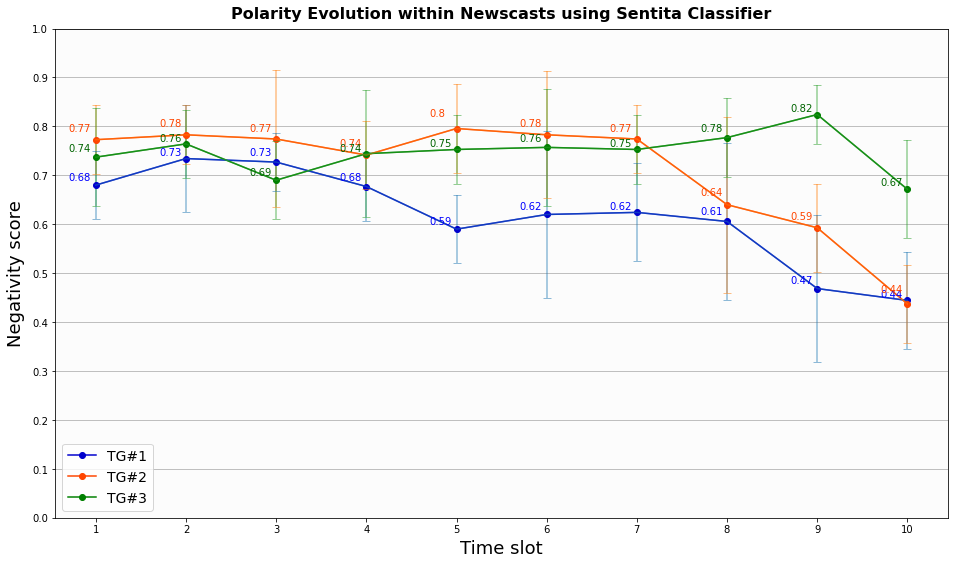

In [30]:
# Sentita

%matplotlib inline
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(np.arange(1,11,1), TGA_chunks_avg_score, label='TG#1', color='mediumblue', marker='o')
ax.errorbar(np.arange(1,11), TGA_chunks_avg_score, yerr=TGA_chunks_std_error, capsize=4, alpha=0.5)
ax.plot(np.arange(1,11,1), TGB_chunks_avg_score, label='TG#2', color='orangered', marker='o')
ax.errorbar(np.arange(1,11), TGB_chunks_avg_score, yerr=TGB_chunks_std_error, capsize=4, alpha=0.5)
ax.plot(np.arange(1,11,1), TGC_chunks_avg_score, label='TG#3', color='green', marker='o')
ax.errorbar(np.arange(1,11), TGC_chunks_avg_score, yerr=TGC_chunks_std_error, capsize=4, alpha=0.5)

# Set plot background color
ax.set_facecolor('#fcfcfc')

# Change the color of the left and bottom spines to black
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

# Labels
ax.set_xlabel("Time slot", labelpad=5)
ax.set_ylabel("Negativity score", labelpad=7)
# Tweak the axis labels
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_size(18)
#ylab.set_style('italic')
ylab.set_size(18)

# Ticks
xtick = ax.set_xticks(np.arange(1,11,1))
ytick = ax.set_yticks(np.arange(0,1.1,0.1))

# Add values to bars
for i in np.arange(0,10):
    plt.text(i+0.7,round(TGA_chunks_avg_score[i],2)+0.01,round(TGA_chunks_avg_score[i],2),color='blue')
    plt.text(i+0.7,round(TGB_chunks_avg_score[i],2)+0.02,round(TGB_chunks_avg_score[i],2),color='orangered')
    plt.text(i+0.7,round(TGC_chunks_avg_score[i],2)+0.01,round(TGC_chunks_avg_score[i],2),color='darkgreen')
    
# Title
ttl = ax.set_title('Polarity Evolution within Newscasts using Sentita Classifier', pad=10)
ttl.set_weight('bold')
ttl.set_size(16)

plt.legend(fontsize=14, loc='lower left')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

In [47]:
# FEEL-IT

TGA_chunks_avg_score = []
TGB_chunks_avg_score = []
TGC_chunks_avg_score = []

TGA_chunks_std_error = []
TGB_chunks_std_error = []
TGC_chunks_std_error = []

for chunks_list in [TGA_chunks_feelit,TGB_chunks_feelit,TGC_chunks_feelit]:  
    for chunk_scores in chunks_list: 
        if chunks_list == TGA_chunks_feelit:
            # Compute chunk mean score
            avg_score = np.mean(chunk_scores)
            TGA_chunks_avg_score.append(avg_score)
            # Compute chunk standard error
            std_error = round(np.std(chunk_scores),2)
            TGA_chunks_std_error.append(std_error)
        elif chunks_list == TGB_chunks_feelit:
            # Compute chunk mean score
            avg_score = np.mean(chunk_scores)
            TGB_chunks_avg_score.append(avg_score)
            # Compute chunk standard error
            std_error = round(np.std(chunk_scores),2)
            TGB_chunks_std_error.append(std_error)
        elif chunks_list == TGC_chunks_feelit:
            # Compute chunk mean score
            avg_score = np.mean(chunk_scores)
            TGC_chunks_avg_score.append(avg_score)
            # Compute chunk standard error
            std_error = round(np.std(chunk_scores),2)
            TGC_chunks_std_error.append(std_error)

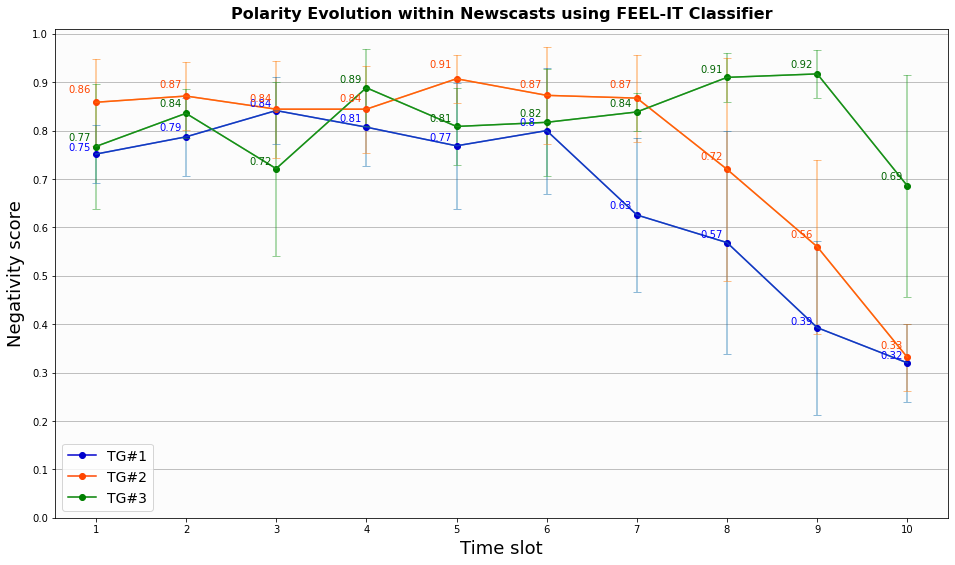

In [48]:
# FEEL-IT

%matplotlib inline
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(np.arange(1,11,1), TGA_chunks_avg_score, label='TG#1', color='mediumblue', marker='o')
ax.errorbar(np.arange(1,11), TGA_chunks_avg_score, yerr=TGA_chunks_std_error, capsize=4, alpha=0.5)
ax.plot(np.arange(1,11,1), TGB_chunks_avg_score, label='TG#2', color='orangered', marker='o')
ax.errorbar(np.arange(1,11), TGB_chunks_avg_score, yerr=TGB_chunks_std_error, capsize=4, alpha=0.5)
ax.plot(np.arange(1,11,1), TGC_chunks_avg_score, label='TG#3', color='green', marker='o')
ax.errorbar(np.arange(1,11), TGC_chunks_avg_score, yerr=TGC_chunks_std_error, capsize=4, alpha=0.5)

# Set plot background color
ax.set_facecolor('#fcfcfc')

# Change the color of the left and bottom spines to black
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

# Labels
ax.set_xlabel("Time slot", labelpad=5)
ax.set_ylabel("Negativity score", labelpad=7)
# Tweak the axis labels
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_size(18)
#ylab.set_style('italic')
ylab.set_size(18)

# Ticks
xtick = ax.set_xticks(np.arange(1,11,1))
ytick = ax.set_yticks(np.arange(0,1.1,0.1))

# Add values to bars
for i in np.arange(0,10):
    plt.text(i+0.7,round(TGA_chunks_avg_score[i],2)+0.01,round(TGA_chunks_avg_score[i],2),color='blue')
    plt.text(i+0.7,round(TGB_chunks_avg_score[i],2)+0.02,round(TGB_chunks_avg_score[i],2),color='orangered')
    plt.text(i+0.7,round(TGC_chunks_avg_score[i],2)+0.01,round(TGC_chunks_avg_score[i],2),color='darkgreen')
    
# Title
ttl = ax.set_title('Polarity Evolution within Newscasts using FEEL-IT Classifier', pad=10)
ttl.set_weight('bold')
ttl.set_size(16)

plt.legend(fontsize=14, loc='lower left')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

In [49]:
# Make values in df_*['Sentita score'] comparable to df_*['FEEL-IT score']
# Both classifiers scores become of the same format -> 0: negative, 1: positive

df_A['Sentita score'] = [1 if score == 0 else 0 for score in df_A['Sentita score']]
df_B['Sentita score'] = [1 if score == 0 else 0 for score in df_B['Sentita score']]
df_C['Sentita score'] = [1 if score == 0 else 0 for score in df_C['Sentita score']]

In [90]:
def display_scores_info(df):
    '''Display info such as length of the dataframe
    where sentences are stored, the total number of equal 
    Sentita and FEEL-IT scores and the percentage out of
    the total number of sentences.
    
    In input, choose the TV news you want selecting df_A, df_B or df_C 
    '''
    equal_score_abs = sum(df['Sentita score']==df['FEEL-IT score'])
    equal_score_perc = round(sum(df['Sentita score']==df['FEEL-IT score']) / len(df),2)
    
    print(f'A total of {equal_score_abs} sentences have the same score')
    print(f'The total number of sentences is {len(df)}')
    print(f'The percentage of sentences with the same score is {equal_score_perc}%')

In [92]:
print(f'\n### SCORES INFO FOR TG#1 ###\n')
display_scores_info(df_A)
print(f'\n### SCORES INFO FOR TG#2 ###\n')
display_scores_info(df_B)
print(f'\n### SCORES INFO FOR TG#3 ###\n')
display_scores_info(df_C)


### SCORES INFO FOR TG#1 ###

A total of 1646 sentences have the same score
The total number of sentences is 2262
The percentage of sentences with the same score is 0.73%

### SCORES INFO FOR TG#2 ###

A total of 1486 sentences have the same score
The total number of sentences is 1924
The percentage of sentences with the same score is 0.77%

### SCORES INFO FOR TG#3 ###

A total of 1176 sentences have the same score
The total number of sentences is 1502
The percentage of sentences with the same score is 0.78%


In [93]:
def get_sentences_different_score(df):
    ''' 
    Create a subset of 5 samples
    Sentita score must differ from FEEL-IT score
    This function provides examples of sentences
    that have been classified differently
    '''
    df_subset = df.loc[df['Sentita score']!=df['FEEL-IT score']]
    
    random_idx = []
    for selection in range(0,5):
        random_idx.append(random.choice(df_subset.index))
        
    return df.loc[random_idx]        

In [94]:
# Choose the TV news you want selecting df_A, df_B or df_C
pd.set_option('display.max_colwidth', None)
TGA_different_scores = get_sentences_different_score(df_A)
TGA_different_scores

,Sentence,Sentita score,FEEL-IT score
286,"Ascoltiamo un brano di una delle sue canzoni più famose, una parentesi di una mezzora brucerà Piccola stella senza cielo ti mostrerà e ci incontreremo mentre scoppia in volo Lotti sceglierà dietro una scia, un soffio velo Buonasera Ligabue.",0,1
322,"Sulla carta Netflix aveva fatto ponti d'oro un contratto da cento milioni di dollari una fortuna che avrebbe messo al sicuro per anni le finanze della coppia, Accordo che ora scricchiola.",1,0
1055,I volontari le hanno dato vestiti puliti e qualcosa da mangiare.,1,0
75,"Il sindaco Ivan Fedorov ci risponde da Sap Orisha, dove si è rifugiato dopo il sequestro opera delle forze russe, la prigionia un'esperienza che lo ha reso un simbolo della resistenza civile all' occupazione.",0,1
800,Questo ha aggiunto il ministro Di Maio e il conflitto resta al centro anche del dibattito politico.,1,0
